In [39]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D
import scipy.special as sp
from scipy.optimize import curve_fit

import slmsuite.holography.toolbox as toolbox
#import pandas as pd

In [40]:
def gaussian_sh(x, a, w, x0):
    return a*np.exp(-2*(x-x0)**2/w**2)

# New function for 2D plotting:
# only works for square images
# note to convert between length_arr = larr to pixelnum:
# (M/pixsize)*larr + shift = pixnum
def splot2(axis, img, xaxis=True):
    data = img[:, 0] # to use len(data)
    pixelnum = np.arange(0, len(data))
    pns = pixelnum # pixelnum no shift
    shift =  len(data)/2
    pixelnum = pixelnum-shift
    # Shift to actual length scale.
    pixelsize = 3.450 # um
    magnification = 1
    actual_length = pixelsize/magnification # in um
    larr = actual_length*pixelnum


    xm, ym = np.meshgrid(larr, larr)

    #print(img.shape) --> don't forget img has 3 color chanels
    #print(img.ravel().shape)
    #print(xm.shape)

    # Also plot the theoretical on-axis PSF
    popt, pcov = curve_fit(gaussian2D, (xm, ym), img[:, :, 0].ravel())

  
    xfit = np.linspace(larr[0], larr[-1], 2000)
    axis.plot(xfit, gaussian_sh(xfit, popt[0], popt[1], popt[2]), label="x-axis fit, wx = "+str(np.round(popt[1], 2))+"um", ls="--", c="g")
    axis.plot(xfit, gaussian_sh(xfit, popt[0], popt[3], popt[4]), label="y-axis fit, wy = "+str(np.round(popt[3], 2))+"um", ls="--", c="r")

    return larr, popt, pcov, [magnification, pixelsize, shift]


# 2D shifted gausian with different waists
def gaussian2D(X, a, wx, x0, wy, y0):
    x, y = X
    g =  a*np.exp((-2 * ((x-x0)**2/wx**2)) + (-2 * ((y-y0)**2/wy**2)))
    return g.ravel()

def plot_final_array(img, params):
    x1, length, y1, height, box_size = params[0], params[1], params[2], params[3], params[4]
    # Plot extraction
    fig = plt.figure(figsize=(10,5))

    # Final extraction:
    norm = img[y1:y1+height, x1:x1+length]

    # Make subplots
    ax00 = fig.add_subplot(1,2,1)
    ax01 = fig.add_subplot(1,2,2)
    
    larr, popt, pcov, tra = splot2(ax00, norm)

    # Get the fitted center positions
    xc = popt[2]
    yc = popt[4]

    # Unpack transformation parameters
    M = tra[0]
    ps = tra[1]
    shift = tra[2]    

    # Convert back to camera coordinates
    xc = (M/ps)*xc + shift
    yc = (M/ps)*yc + shift

    # Convert center positions to pixels via rounding
    xc = int(np.round(xc))
    yc = int(np.round(yc))

    #print(xc, yc)
    norm = norm[:, :, 0] # select only one color channel
    #xdata = norm[yc, :]
    #ydata = norm[:, xc]
    
    #ax00.scatter(larr, xdata, c = "g", s=5)
    #ax00.scatter(larr, ydata, c = "r", s=5)

    #ax01.legend()
    ax00.legend()

    # Show image
    ax01.imshow(norm)
    ax01.axvline(xc, c="red")     # x-axis
    ax01.axhline(yc, c="green")   # y-axis

    fig.tight_layout()

    plt.subplots_adjust(top=0.92)

    return norm, larr, popt, pcov # Return first color channel of norm

In [ ]:
# Connect to a camera and an SLM

#cam.close()
#slm.close()

### Camera
from slmsuite.hardware.cameras.thorlabs import ThorCam
ThorCam.info(verbose=True)

# Serial number is 23910 for the Zelux, apparently.
cam = ThorCam(serial="23910", verbose=True, fliplr=False) 

### SLM 
from slmsuite.hardware.slms.screenmirrored import ScreenMirrored
ScreenMirrored.info(verbose=True)
slm = ScreenMirrored(display_number = 1, wav_um=.589, wav_design_um = .700)

### Make a composite optical system -- a Fourier pair.
from slmsuite.hardware.cameraslms import FourierSLM
fs = FourierSLM(cam, slm)
#fs.load_wavefront_calibration(plot=True)

In [ ]:
# Perform Fourier Calibration

cam.set_exposure(0.012)
fs.fourier_calibrate(array_shape=[5, 5], array_pitch=[30, 30], plot=True)

cam.set_exposure(.002) # Restore exposure

In [ ]:
# Create a simple array

pitch = 20 # pixels

xlist = np.arange(1000, 1060, pitch)
ylist = np.arange(1000, 1060, pitch)
xgrid, ygrid = np.meshgrid(xlist, ylist)
square = np.vstack((xgrid.ravel(), ygrid.ravel()))

plt.scatter(square[0, :], square[1, :], s=2)
plt.xlim([0, fs.cam.shape[1]]); plt.ylim([fs.cam.shape[0], 0])
plt.show()
print(xlist)
print(ylist)

In [ ]:
# Ceate the hologram

from slmsuite.holography.algorithms import SpotHologram
hologram = SpotHologram(shape=(2048, 2048), spot_vectors=square, basis="ij", cameraslm=fs)

hologram.plot_farfield(hologram.target,  limits=[[800, 1200], [800, 1200]], title="Target")

In [ ]:
# Calculate Phase Pattern

hologram.optimize('WGS-Kim', feedback='computational_spot', stat_groups=['computational_spot'], maxiter=50)
hologram.plot_farfield(limits=[[800, 1200], [800, 1200]], title="After Optimization")

In [ ]:
# Write to the SLM and get camera image

# Experimentally:
fs.slm.write(hologram.extract_phase(), settle=True)             # Write hologram.
fs.cam.set_exposure(.0015)
fs.cam.flush()
img = fs.cam.get_image()                                        # Grab image.

plt.figure(figsize=(24,24));    plt.imshow(img, vmax=50)        # This is saturated for visibility.
plt.xlabel("Image $x$ [pix]");  plt.ylabel("Image $y$ [pix]")
plt.show()

In [41]:
hori_arrays = []
data_arrays = []
popt_arrays = []
pcov_arrays = []

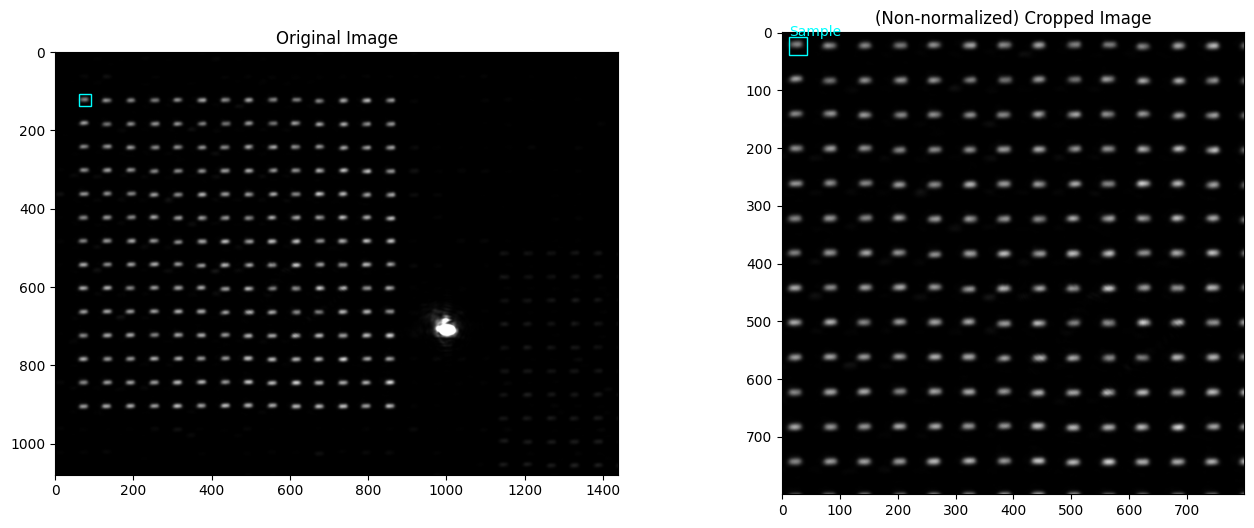

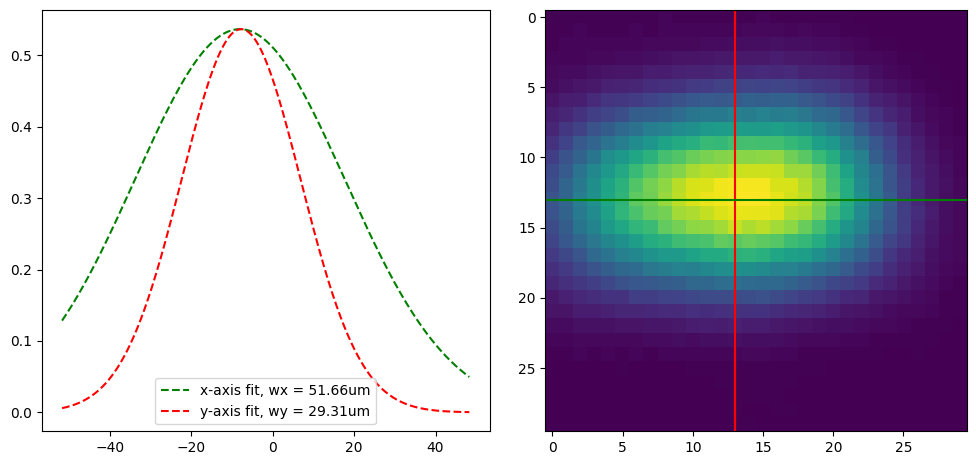

In [42]:
# User input
box_size = 30
spot_coords = np.array([[62], [108]])
x_coords = spot_coords[0]
y_coords = spot_coords[1]
spot_coords = np.concatenate([x_coords[:,None], y_coords[:,None]], axis=1)

# Suppose we had a camera image
filepath = 'static/images/7090paint.png'

for p in spot_coords:
    
    # Get the full image
    img = plt.imread(filepath)

    # Create the figure with 2 subplots
    fig0,ax0 = plt.subplots(1, 2, figsize=(16,6))

    # Show the uncropped image on the first subplot
    ax0[0].imshow(img)
    ax0[0].set_title("Original Image")

    # Crop image to get relevant part
    cropx = 50
    x_len = 800
    cropy = 100
    y_len = 800
    img = plt.imread(filepath)
    img = img[cropy:cropy+y_len, cropx:cropx+x_len]

    # Add Box
    x1 = p[0] - cropx
    length = box_size
    y1 = p[1] - cropy
    height = box_size
    params = [x1, length, y1, height, box_size]
    rect1 = patches.Rectangle((x1, y1), length, height, linewidth=1, edgecolor="cyan", facecolor="none")
    ax0[1].add_patch(rect1)
    ax0[1].text(x1, y1-2,'Sample', c="cyan")

    # Display cropped image on second subplot
    ax0[1].imshow(img)
    ax0[1].set_title("(Non-normalized) Cropped Image")

    # Also add the box to the first subplot
    rect_corrected = patches.Rectangle((x1+cropx, y1+cropy), length, height, linewidth=1, edgecolor="cyan", facecolor="none")
    ax0[0].add_patch(rect_corrected)

    # Cropped image for final plot
    fp_img = plt.imread(filepath) # final plot image
    fp_img = fp_img[cropy:cropy+y_len, cropx:cropx+x_len]

    norm, larr, popt, pcov = plot_final_array(fp_img, params)
    popt_arrays.append(popt)
    pcov_arrays.append(pcov)

Text(0.5, 1.0, 'mean = 1.0, median = 1.0, std dev = 0.0')

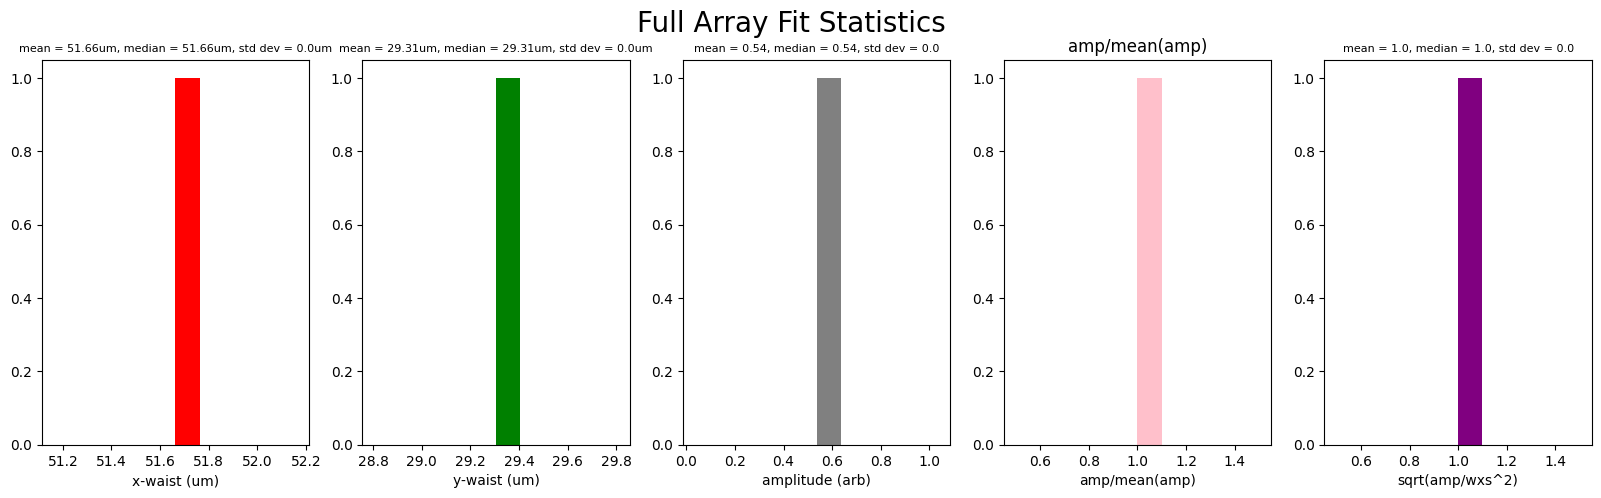

In [43]:
# Histograms
hfig, hax = plt.subplots(1, 5, figsize=(20,5))

plt.suptitle("Full Array Fit Statistics", fontsize=20)

#Extract all waists
wxs = []
wys = []
a_arr = []
for popt in popt_arrays:
    a_arr.append(popt[0])
    wxs.append(popt[1])
    wys.append(popt[3])

wxs = np.array(wxs)
wys = np.array(wys)
a_arr = np.array(a_arr)

hax[0].hist(wxs, color= "r", label="x-waist")
hax[0].set_xlabel("x-waist (um)")
hax[0].set_title("mean = {}um, median = {}um, std dev = {}um".format(round(np.mean(wxs),2), round(np.median(wxs),2), round(np.std(wxs),2)), fontsize=8)

hax[1].hist(wys, color="g", label="y-waist")
hax[1].set_xlabel("y-waist (um)")
hax[1].set_title("mean = {}um, median = {}um, std dev = {}um".format(round(np.mean(wys),2), round(np.median(wys),2), round(np.std(wys),2)), fontsize=8)

hax[2].hist(a_arr, color="gray", label="amplitude")
hax[2].set_xlabel("amplitude (arb)")
hax[2].set_title("mean = {}, median = {}, std dev = {}".format(round(np.mean(a_arr),2), round(np.median(a_arr),2), round(np.std(a_arr),2)), fontsize=8)

hax[3].hist(a_arr/np.mean(a_arr), color="pink")
hax[3].set_xlabel("amp/mean(amp)")
hax[3].set_title("amp/mean(amp)")

p4 = np.sqrt(a_arr/wxs**2)
p4 = p4/np.mean(p4)
hax[4].hist(p4, color="purple")
hax[4].set_xlabel("sqrt(amp/wxs^2)")
hax[4].set_title("mean = {}, median = {}, std dev = {}".format(round(np.mean(p4),2), round(np.median(p4),2), round(np.std(p4),2)), fontsize=8)

In [44]:
def nelder_mead(f, initial_point, initial_step, tolerance, maxiter, alpha, gamma, rho, sigma):
    
    # Create the initial simplex

    # Initialize simplex with the initial point
    current_simplex = [[initial_point, f(initial_point)]]
    # Dimension of each point
    dim = len(initial_point)
    
    # Add initial step to each dimension of initial point to create initial simplex
    for i in range(dim):
        initial_point_copy = np.copy(initial_point)
        initial_point_copy[i] = initial_point_copy[i] + initial_step
        current_simplex.append([initial_point_copy, f(initial_point_copy)])

    print(current_simplex)

    iter = 0

    while True:
        
        iter += 1
        print(iter)

        # Order the points by function value
        ordered_simplex = sorted(current_simplex, key=lambda x: float(x[1]))
        print(ordered_simplex)

        # Check for termination
        if iter == maxiter:
            # Return best point and function value
            return ordered_simplex[0]
        else:
            # Calculate centroid
            centroid_point = centroid(ordered_simplex[:-1])

            # Calculate reflected point
            worst_point = ordered_simplex[-1][0]
            reflected_point = reflected(centroid_point, alpha, worst_point)

            best_point_value = ordered_simplex[0][1]
            second_worst_point_value = ordered_simplex[-2][1]
            reflected_point_value = f(reflected_point)

            if best_point_value <= reflected_point_value < second_worst_point_value:
                # Replace worst with reflected point
                ordered_simplex.pop()
                ordered_simplex.append([reflected_point, reflected_point_value])
                current_simplex = ordered_simplex
                print('Swapped worst with reflected')
                continue
            elif reflected_point_value < best_point_value:

                # Calculate expanded point
                expanded_point = expanded(centroid_point, gamma, reflected_point)
                expanded_point_value = f(expanded_point)

                if expanded_point_value < reflected_point_value:
                    # Replace worst with expanded
                    ordered_simplex.pop()
                    ordered_simplex.append([expanded_point, expanded_point_value])
                    current_simplex = ordered_simplex
                    print('Swapped worst with expanded')
                    continue
                else:
                    ordered_simplex.pop()
                    ordered_simplex.append([reflected_point, reflected_point_value])
                    current_simplex = ordered_simplex
                    print('Swapped worst with reflected')
                    continue    
            else:
                worst_point_value = ordered_simplex[-1][1]
                if reflected_point_value < worst_point_value:
                    # Calculate outside contracted point
                    contracted_point = contraction_outside(centroid_point, rho, reflected_point)
                    contracted_point_value = f(contracted_point)

                    if contracted_point_value < reflected_point_value:
                        # Replace worst with contracted
                        ordered_simplex.pop()
                        ordered_simplex.append([contracted_point, contracted_point_value])
                        current_simplex = ordered_simplex
                        print('Swapped worst with outside contracted')
                        continue
                    else:
                        # Replace all but the best point with shrunk points
                        current_simplex = shrink(ordered_simplex, sigma)
                        print("Shrunk points")
                        continue
                        
                elif reflected_point_value >= worst_point_value:
                    # Calculate inside contracted point
                    contracted_point = contraction_inside(centroid_point, rho, worst_point)
                    contracted_point_value = f(contracted_point)

                    if contracted_point_value < worst_point_value:
                        # Replace worst with contracted
                        ordered_simplex.pop()
                        ordered_simplex.append([contracted_point, contracted_point_value])
                        current_simplex = ordered_simplex
                        print('Swapped worst with inside contracted')
                        continue
                    else:
                        # Replace all but the best point with shrunk points
                        current_simplex = shrink(ordered_simplex, sigma)
                        print('Shrunk points')
                        continue       

def centroid(simplex):
    num_points = len(simplex)
    dim_points = len(simplex[0][0])
    point_sum = np.zeros(dim_points)
    for p in simplex:
        point_sum = point_sum + p[0]
    return point_sum / num_points

def reflected(centroid, alpha, worst_point):

    return centroid + alpha * (centroid - worst_point)

def expanded(centroid, gamma, reflected):
    return centroid + gamma * (reflected - centroid)

def contraction_outside(centroid, rho, reflected):
    return centroid + rho * (reflected - centroid)

def contraction_inside(centroid, rho, worst):
    return centroid + rho * (worst - centroid)

def shrink(simplex, sigma):
    best_point = simplex[0][0]
    for p in simplex[1:]:
        p[0] = best_point + sigma * (p[0] - best_point)

    return simplex

def termination(simplex):
    return 1

In [ ]:
# THE FUNCTION WE ARE PUTTING INTO NELDER MEAD

# Calculate how close an array is to being uniform based on some linear combination of zernikes

# Takes in a 10D vector containing the coeff for each zernike
def loss_function(v):
    
    # Get the zernike
    zernike_sum_phase = toolbox.phase.zernike_sum(
        grid=slm,
        weights=(
            ((2, 0),  1),                   # Z_20 (weighted by +1)
            ((2, 1), -1),                   # Z_21 (weighted by -1)
            ((3, 1),  1)                    # Z_31 (weighted by +1)
        )
    )
    # Add the zernike to the base

    # Write to the SLM

    # Take the camera image

    # Run the fit over all the spots

    # Display hologram of fit statistics

    # Calculate the loss from the fit statistics

    # Return the loss
